[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tranngocduvnvp/CTCDFormer/blob/main/CTDCFormerB4.ipynb)

In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.8 MB/s eta 0:00:00


In [2]:
!pip install torchgeometry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 KB 4.0 MB/s eta 0:00:00


In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 10.9 MB/s eta 0:00:00


In [4]:
!pip3 install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [9]:
!pip install texttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!gdown 1wKiVxrOWtn2JjTMXNoED2FGsT98AMKW6

Downloading...
From: https://drive.google.com/uc?id=1wKiVxrOWtn2JjTMXNoED2FGsT98AMKW6
To: /content/data_new.zip
100% 399M/399M [00:03<00:00, 109MB/s]


In [ ]:
!unzip ./data_new.zip

In [ ]:
# !wget https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b2.pth
# !wget https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b3.pth
# !wget https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b4.pth

In [10]:
import random
import cv2
import torch
from torch.utils import data
import torchvision.transforms.functional as TF
import numpy as np
import random
import multiprocessing
import timm
import torchmetrics
import sys
import os
import argparse
import time
import numpy as np
import glob

import torch.nn as nn
import torchmetrics.functional.classification as Fmstric
import torchgeometry as tgm


import torch.nn.functional as F
from functools import partial
from timm.models.vision_transformer import _cfg
from texttable import Texttable


from sklearn.model_selection import train_test_split
from torchvision import transforms
import glob
import matplotlib.pyplot as plt


In [27]:
class Args:
    def __init__(self,root, epochs, batch_size, dataset, mgpu, lrs_min,\
                 lrs, lr, type_lr, checkpoint_path, backbone, optim):
        self.root = root
        self.epochs = epochs
        self.batch_size = batch_size
        self.dataset = dataset
        self.mgpu = mgpu
        self.lrs_min = lrs_min
        self.lrs = lrs
        self.lr = lr
        self.type_lr = type_lr
        self.checkpoint_path = checkpoint_path
        self.backbone = backbone
        self.optim = optim
        
args = Args(
    root="./data_new", 
    epochs=80, 
    batch_size=4, 
    dataset="generalizability_Unet3",
    mgpu="false",
    lrs="true",
    lrs_min=1e-6,
    lr = 3e-4,
    type_lr = "StepLR",
    checkpoint_path = None,
    backbone="PvtB3",
    optim="Adam"
)
args.root

'./data_new'

# Make Dataset

In [12]:
class SegDataset(data.Dataset):
    def __init__(
        self,
        input_paths: list,
        target_paths: list,
        transform_input=None,
        transform_target=None,
        hflip=False,
        vflip=False,
        affine=False,
    ):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.hflip = hflip
        self.vflip = vflip
        self.affine = affine

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, index: int):
        input_ID = self.input_paths[index]
        target_ID = self.target_paths[index]

        x = cv2.cvtColor(cv2.imread(input_ID), cv2.COLOR_BGR2RGB)
        y = cv2.cvtColor(cv2.imread(target_ID), cv2.COLOR_BGR2RGB)
        x = self.transform_input(x)
        y = self.transform_target(y)

        if self.hflip:
            if random.uniform(0.0, 1.0) > 0.5:
                x = TF.hflip(x)
                y = TF.hflip(y)

        if self.vflip:
            if random.uniform(0.0, 1.0) > 0.5:
                x = TF.vflip(x)
                y = TF.vflip(y)

        if self.affine:
            angle = random.uniform(-180.0, 180.0)
            h_trans = random.uniform(-352 / 8, 352 / 8)
            v_trans = random.uniform(-352 / 8, 352 / 8)
            scale = random.uniform(0.5, 1.5)
            shear = random.uniform(-22.5, 22.5)
            x = TF.affine(x, angle, (h_trans, v_trans), scale, shear, fill=-1.0)
            y = TF.affine(y, angle, (h_trans, v_trans), scale, shear, fill=0.0)
        return x.float(), y.float()



In [14]:
def split_ids(len_ids):
    train_size = int(round((80 / 100) * len_ids))
    valid_size = int(round((10 / 100) * len_ids))
    test_size = int(round((10 / 100) * len_ids))

    train_indices, test_indices = train_test_split(
        np.linspace(0, len_ids - 1, len_ids).astype("int"),
        test_size=test_size,
        random_state=42,
    )

    train_indices, val_indices = train_test_split(
        train_indices, test_size=test_size, random_state=42
    )

    return train_indices, test_indices, val_indices


def get_dataloaders(root_train, root_test, batch_size):
    input_paths_train = sorted(glob.glob(root_train + "/images/*"))
    target_path_train = sorted(glob.glob(root_train + "/masks/*"))
    dataset_test = ["Kvasir", "ETIS-LaribPolypDB", "CVC-ColonDB", "CVC-ClinicDB","CVC-300"]
    path_image_test = {}
    path_mask_test = {}
    for item_name in dataset_test:
        path_image_test[item_name] = sorted(glob.glob(root_test + f"/{item_name}" + "/images/*"))
        path_mask_test[item_name] = sorted(glob.glob(root_test + f"/{item_name}" + "/masks/*"))

    transform_input4train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((352, 352), antialias=True),
            transforms.GaussianBlur((25, 25), sigma=(0.001, 2.0)),
            transforms.ColorJitter(
                brightness=0.4, contrast=0.5, saturation=0.25, hue=0.01
            ),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
        ]
    )

    transform_input4test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((352, 352), antialias=True),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
        ]
    )

    transform_target = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((352, 352)), transforms.Grayscale()]
    )

    train_dataset = SegDataset(
        input_paths=input_paths_train,
        target_paths=target_path_train,
        transform_input=transform_input4train,
        transform_target=transform_target,
        hflip=True,
        vflip=True,
        affine=True,
    )
    test_dataset = {}
    for item in path_image_test:
      test_dataset[item] = SegDataset(
        input_paths=path_image_test[item],
        target_paths=path_mask_test[item],
        transform_input=transform_input4test,
        transform_target=transform_target,)

    
    train_dataloader = data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=multiprocessing.Pool()._processes,
    )
    test_dataloader = {}
    for item in test_dataset:
      test_dataloader[item] = data.DataLoader(
        dataset=test_dataset[item],
        batch_size=1,
        shuffle=False,
        num_workers=multiprocessing.Pool()._processes,)



    return train_dataloader, test_dataloader



root_train = "./data_new/TrainDataset"
root_test = "./data_new/TestDataset"
train_dataloader, test_dataloader = get_dataloaders(
    root_train,
    root_test,
    4
)
        
image, mask = next(iter(train_dataloader))

In [15]:
def show(img, mask):
    plt.subplot(1,2,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(mask[0][0], cmap="gray")
    plt.xticks([])
    plt.yticks([])

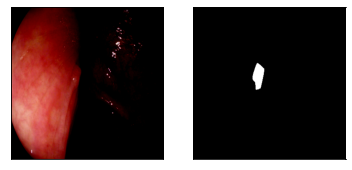

In [16]:
image, mask = next(iter(test_dataloader["ETIS-LaribPolypDB"])) 
show(image, mask)

# make model

## Backbone

## MIT

In [17]:
import warnings

from functools import partial
from timm.models.layers import to_2tuple, trunc_normal_
import math
from timm.models.layers import DropPath
import torch.nn as nn
import torch

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.embed_dims = embed_dims

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


class mit_b0(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b1(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b2(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b3(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b4(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b5(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        
class Feature_extractor_MIT(nn.Module):

    def __init__(self,model_type="MitB0", embedding_dim = 160):
        super(Feature_extractor_MIT, self).__init__()
        self.model_type = model_type
        # Backbone
        if self.model_type == 'MitB0':
            self.backbone = mit_b0()
            self.channel = [32, 64, 160, 256]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if self.model_type == 'MitB1':
            self.backbone = mit_b1()
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if self.model_type == 'MitB2':
            self.backbone = mit_b2()
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if self.model_type == 'MitB3':
            self.backbone = mit_b3()
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if self.model_type == 'MitB4':
            self.backbone = mit_b4()
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if self.model_type == 'MitB5':
            self.backbone = mit_b5()
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        self._init_weights()  # load pretrain
        
        
    def _init_weights(self):
        
        if self.model_type == 'MitB0':
            pretrained_dict = torch.load('./Pretrained/mit_b0.pth')
        if self.model_type == 'MitB1':
            pretrained_dict = torch.load('./Pretrained/mit_b1.pth')
        if self.model_type == 'MitB2':
            pretrained_dict = torch.load('./Pretrained/mit_b2.pth')
        if self.model_type == 'MitB3':
            pretrained_dict = torch.load('./Pretrained/mit_b3.pth')
        if self.model_type == 'MitB4':
            pretrained_dict = torch.load('./Pretrained/mit_b4.pth')
        if self.model_type == 'MitB5':
            pretrained_dict = torch.load('./Pretrained/mit_b5.pth')
            
            
        model_dict = self.backbone.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.backbone.load_state_dict(model_dict)
        print("successfully loaded!!!!")
        
        
    def forward(self, x):
        
        ##################  Go through backbone ###################
        
        B = x.shape[0]
        
        #stage 1
        out_1, H, W = self.backbone.patch_embed1(x)
        for i, blk in enumerate(self.backbone.block1):
            out_1 = blk(out_1, H, W)
        out_1 = self.backbone.norm1(out_1)
        out_1 = out_1.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[0], 88, 88)
        
        # stage 2
        out_2, H, W = self.backbone.patch_embed2(out_1)
        for i, blk in enumerate(self.backbone.block2):
            out_2 = blk(out_2, H, W)
        out_2 = self.backbone.norm2(out_2)
        out_2 = out_2.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[1], 44, 44)
        
        # stage 3
        out_3, H, W = self.backbone.patch_embed3(out_2)
        for i, blk in enumerate(self.backbone.block3):
            out_3 = blk(out_3, H, W)
        out_3 = self.backbone.norm3(out_3)
        out_3 = out_3.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[2], 22, 22)
        
        # stage 4
        out_4, H, W = self.backbone.patch_embed4(out_3)
        for i, blk in enumerate(self.backbone.block4):
            out_4 = blk(out_4, H, W)
        out_4 = self.backbone.norm4(out_4)
        out_4 = out_4.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[3], 11, 11)
        
        return out_1, out_2, out_3, out_4
    
# model = Feature_extractor_MIT(model_type = "MitB5")
# x = torch.rand(2,3,352,352)
# outs = model(x)
# channels = []
# for out in outs:
#     print(out.shape)
#     channels.append(out.shape[1])
# print(channels)

##Pvit

In [19]:

#Ported from https://github.com/whai362/PVT (unmodified)

import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., linear=False):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.linear = linear
        if self.linear:
            self.relu = nn.ReLU(inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        if self.linear:
            x = self.relu(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1, linear=False):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.linear = linear
        self.sr_ratio = sr_ratio
        if not linear:
            if sr_ratio > 1:
                self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
                self.norm = nn.LayerNorm(dim)
        else:
            self.pool = nn.AdaptiveAvgPool2d(7)
            self.sr = nn.Conv2d(dim, dim, kernel_size=1, stride=1)
            self.norm = nn.LayerNorm(dim)
            self.act = nn.GELU()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if not self.linear:
            if self.sr_ratio > 1:
                x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
                x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
                x_ = self.norm(x_)
                kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            else:
                kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(self.pool(x_)).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            x_ = self.act(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1, linear=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio, linear=linear)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, linear=linear)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        
        assert max(patch_size) > stride, "Set larger patch_size than stride"
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // stride, img_size[1] // stride
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerV2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], num_stages=4, linear=False):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            patch_embed = OverlapPatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                                            patch_size=7 if i == 0 else 3,
                                            stride=4 if i == 0 else 2,
                                            in_chans=in_chans if i == 0 else embed_dims[i - 1],
                                            embed_dim=embed_dims[i])

            block = nn.ModuleList([Block(
                dim=embed_dims[i], num_heads=num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer,
                sr_ratio=sr_ratios[i], linear=linear)
                for j in range(depths[i])])
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"block{i + 1}", block)
            setattr(self, f"norm{i + 1}", norm)

        # classification head
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        features_maps = []

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            block = getattr(self, f"block{i + 1}")
            norm = getattr(self, f"norm{i + 1}")
            x, H, W = patch_embed(x)
            for blk in block:
                x = blk(x, H, W)
            x = norm(x)
            features_maps.append(x.view(B, H, W, -1).permute(0, 3, 1, 2).contiguous())
            if i != self.num_stages - 1:
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
                # print(i, x.shape)

        return features_maps

    def forward(self, x):
        # print(x.shape)
        x = self.forward_features(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
def pvt_v2_b0(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b1(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b3(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b4(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b5(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2_li(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], linear=True, **kwargs)
    model.default_cfg = _cfg()

    return model

class Feature_extractor_PVT(nn.Module):
    def __init__(self, model_type="PvtB4"):
        super().__init__()
        if model_type == 'PvtB0':
            pretrained_dict = torch.load('./pvt_v2_b0.pth')
            self.backbone = pvt_v2_b0()
            self.backbone.load_state_dict(pretrained_dict)
            print("Load checkpoint successfuly!!")
            self.channel = [32, 64, 160, 256]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if model_type == 'PvtB1':
            pretrained_dict = torch.load('./pvt_v2_b1.pth')
            self.backbone = pvt_v2_b1()
            self.backbone.load_state_dict(pretrained_dict)
            print("Load checkpoint successfuly!!")
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if model_type == 'PvtB2':
            pretrained_dict = torch.load('./pvt_v2_b2.pth')
            self.backbone = pvt_v2_b2()
            self.backbone.load_state_dict(pretrained_dict)
            print("Load checkpoint successfuly!!")
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if model_type == 'PvtB3':
            pretrained_dict = torch.load('./pvt_v2_b3.pth')
            self.backbone = pvt_v2_b3()
            self.backbone.load_state_dict(pretrained_dict)
            print("Load checkpoint successfuly!!")
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]
        if model_type == 'PvtB4':
            pretrained_dict = torch.load('./pvt_v2_b4.pth')
            self.backbone = pvt_v2_b4()
            self.backbone.load_state_dict(pretrained_dict)
            print("Load checkpoint successfuly!!")
            self.channel = [64, 128, 320, 512]
            self.scale = [1/8, 1/4, 1/2, 1/1, 2, 4, 8]


    def forward(self, x):
        features = self.backbone(x)

        return features

# x = torch.rand(2,3,224,224)
# model = Feature_extractor_PVT()
# out = model(x)
# for item in out:
#     print(item.shape)
# # print(out.shape)

## model

## Module

In [20]:
class EFFat(nn.Module):

    def __init__(self, channel=512,reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) + self.max_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x) + x
    

class convMixerLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size) -> None:
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channel, 
            out_channels=in_channel, 
            groups=in_channel, 
            kernel_size=kernel_size,
            stride=1,
            padding="same"
        )
        self.eff = EFFat(out_channel)
        self.pointwise = nn.Conv2d(in_channel, out_channel, 1, 1)
        self.activation = nn.SiLU()
        self.batchnorm1 = nn.BatchNorm2d(in_channel)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)
    
    def forward(self, x):
        ori = x
        x = self.depthwise(x)
        x = self.activation(x)
        x = self.eff(self.batchnorm1(x)) + ori
        x = self.pointwise(x)
        x = self.activation(x)
        x = self.batchnorm2(x)
        return x


class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0 ,bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0 ,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class BottleneckCSP(nn.Module):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = nn.Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1)
        self.bn = nn.BatchNorm2d(2 * c_)  # applied to cat(cv2, cv3)
        self.act = nn.SiLU()
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), 1))))

class Channel_attention(nn.Module):
    def __init__(self, c, reduction=16) -> None:
        super().__init__()
        self.fcap1 = nn.Conv2d(c, c//reduction,1)
        self.fcmp1 = nn.Conv2d(c, c//reduction, 1)
        self.fcap2 = nn.Conv2d(c//reduction, c, 1)
        self.fcmp2 = nn.Conv2d(c//reduction, c, 1)
        self.acg = nn.Conv2d(c//reduction, c, 1)
    def forward(self, x):
        f1 = F.relu(self.fcap1(x))
        f2 = F.relu(self.fcmp1(x))
        f = self.acg(f1 + f2)
        out = F.sigmoid(f + self.fcap2(f1) + self.fcmp2(f2))*x
        return out

class CTblock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3) -> None:
        super().__init__()
        self.mixspatial = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, kernel_size, padding="same", groups=in_channel),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Channel_attention(in_channel),
            nn.Conv2d(in_channel, out_channel, 3, padding="same"),
            nn.BatchNorm2d(out_channel),
        )
        self.mixchannel = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 1, 1),
            nn.BatchNorm2d(out_channel),
        )
    
    def forward(self, x):
        y = F.relu(self.mixspatial(x) + self.mixchannel(x))
        return y


## CTDCFormer

In [21]:
class UpDownstream(nn.Module):
    def __init__(self, scale, in_channel, out_channel) -> None:
        super().__init__()
        self.scale = scale
        self.conv1x1 = nn.Conv2d(in_channel, out_channel, 1)
        self.bn = nn.BatchNorm2d(out_channel)
        self.ac = nn.GELU()
    def forward(self, x):
        x = self.conv1x1(x)
        x = self.bn(x)
        x = self.ac(x)
        bn, c, h, w = x.shape
        x = F.interpolate(x, size=(int(h*self.scale), int(w*self.scale)), mode="bilinear")
        return x

class NormMode(nn.Module):
    def __init__(self, scale, in_channel, out_channel) -> None:
        super().__init__()
        """nhận đầu vào là một tensor cxhxw

        Returns:
            - vector key: d
            - Tensor value: c1xh1xw1
        """
        self.norm = UpDownstream(scale, in_channel, out_channel)
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.mg = nn.AdaptiveMaxPool2d((1,1))
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 1),
            nn.GELU(),
            nn.Conv2d(in_channel, out_channel, 1)
        )

    def forward(self, x):
        v = self.norm(x).unsqueeze(1) # (bs, 1, c, h, w)
        k = self.mlp(self.avg(x)+self.mg(x)).view(x.shape[0], 1, -1) #(bs,1, c)
        return v, k
        

class AttentionDC(nn.Module):
    def __init__(self, scale, in_channel, out_channel) -> None:
        super().__init__()
        self.normfm1 = NormMode(scale[0], in_channel[0], out_channel)
        self.normfm2 = NormMode(scale[1], in_channel[1], out_channel)
        self.normfm3 = NormMode(scale[2], in_channel[2], out_channel)
        self.normfm4 = NormMode(scale[3], in_channel[3], out_channel)
        self.normfmDecode = NormMode(1, out_channel, out_channel)
        self.mlp = nn.Linear(out_channel*2, out_channel)

    
    def forward(self, feature_maps):
        fm1, fm2, fm3, fm4, fmdecode = feature_maps
        v1, k1 = self.normfm1(fm1)
        v2, k2 = self.normfm2(fm2)
        v3, k3 = self.normfm3(fm3)
        v4, k4 = self.normfm4(fm4)
        vd, qd = self.normfmDecode(fmdecode) #(bs, 1, c)
        K = torch.cat([k1, k2, k3, k4], dim=1) #(bs, 4, c)
        K = torch.cat([K, qd.expand_as(K)], dim=2) #(bs, 4, 2c)
        atten = F.softmax(self.mlp(K), dim=1).unsqueeze(-1).unsqueeze(-1)   #(bs, 4, c, 1, 1)
        V = torch.cat([v1,v2,v3,v4], dim=1) #(bs, 4, c, h, w)
        V = V*atten #(bs, 4, c, h, w)
        V = torch.sum(V, dim=1) #(bs, c, h, w)
        V = torch.cat([V, vd.squeeze(1)], dim=1)
        return V

class RB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=2, padding="same"),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

        self.out_layers = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, dilation=2, padding="same"),
            nn.BatchNorm2d(out_channels, out_channels),
            nn.GELU(),
        )

        if out_channels == in_channels:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        h = self.in_layers(x)
        h = self.out_layers(h)
        return h + self.skip(x)

        

class CTDC(nn.Module):
    def __init__(self, args = args) -> None:
        super().__init__()
        if "Mit" in args.backbone:
            self.feature_extractor = Feature_extractor_MIT(args.backbone)
            channel, scale = self.feature_extractor.channel, self.feature_extractor.scale
        elif "Pvt" in args.backbone:
            self.feature_extractor = Feature_extractor_PVT(args.backbone)
            channel, scale = self.feature_extractor.channel, self.feature_extractor.scale
        
        self.attention1 = AttentionDC(scale[:4], channel, channel[-1])
        self.attention2 = AttentionDC(scale[1:5], channel, channel[-2])
        self.attention3 = AttentionDC(scale[2:6], channel, channel[-3])
        self.attention4 = AttentionDC(scale[3:7], channel, channel[-4])
        # self.csp = BottleneckCSP(channel[-1], channel[-1])
        self.rb1 = nn.Sequential(
            RB(channel[-1], channel[-1]),
            RB(channel[-1], channel[-1])
        )
        self.rb2 = nn.Sequential(
            RB(channel[-1]*2, channel[-2]),
            RB(channel[-2], channel[-2]),
        )
        self.rb3 = nn.Sequential(
            RB(channel[-2]*2, channel[-3]),
            RB(channel[-3], channel[-3]),
        )
        self.rb4 = nn.Sequential(
            RB(channel[-3]*2, channel[-4]),
            RB(channel[-4], channel[-4]),
        )
        self.rb5 = nn.Sequential(
            RB(channel[-4]*2, channel[-4]),
            RB(channel[-4], channel[-4])
        )
        self.rb6 = nn.Sequential(
            RB(channel[-4], channel[-4]),
            RB(channel[-4], channel[-4]),
        )
        self.head = nn.Conv2d(channel[-4], 1, 1)

    
    def forward(self, x):
        fm1, fm2, fm3, fm4 = self.feature_extractor(x)
        decode1 = self.rb1(fm4) #328x7x7
        out1 = self.attention1([fm1, fm2, fm3, fm4, decode1]) #756x7x7
        decode2 = F.interpolate(self.rb2(out1), (out1.shape[2]*2, out1.shape[3]*2), mode="bilinear") #192x14x14
        out2 = self.attention2([fm1, fm2, fm3, fm4, decode2]) #384x14x14
        decode3 = F.interpolate(self.rb3(out2), (out2.shape[2]*2, out2.shape[3]*2), mode="bilinear") #80x28x28
        out3 = self.attention3([fm1, fm2, fm3, fm4, decode3]) #160x28x28
        decode4 = F.interpolate(self.rb4(out3), (out3.shape[2]*2, out3.shape[3]*2), mode="bilinear") #56x56x56
        out4 = self.attention4([fm1, fm2, fm3, fm4, decode4]) #112x56x56
        decode5 = F.interpolate(self.rb5(out4), (out4.shape[2]*2, out4.shape[3]*2), mode="bilinear") #32x112x112
        decode6 = F.interpolate(self.rb6(decode5), (decode5.shape[2]*2, decode5.shape[3]*2), mode="bilinear")
        mask_pred = self.head(decode6)
        return mask_pred

# model = CTDC()
# x = torch.rand(2,3,352,352)
# out = model(x)
# print(out.shape)


## Unet3++

In [25]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size), nn.ReLU(inplace=True),)
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size
        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p), nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
        return x

class UNet3Plus(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True, feature_scale=4,
                 is_deconv=True, is_batchnorm=True):
        super(UNet3Plus, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.feature_scale = feature_scale
        self.is_deconv = is_deconv
        self.is_batchnorm = is_batchnorm
        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.n_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return d1

# unetv3 = UNet3Plus()
# x = torch.rand(2,3,320,320)
# out = unetv3(x)

# loss

## DiceLoss

In [22]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num = targets.size(0)

        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = m1 * m2

        score = (
            2.0
            * (intersection.sum(1) + self.smooth)
            / (m1.sum(1) + m2.sum(1) + self.smooth)
        )
        score = 1 - score.sum() / num
        return score


## FocalLoss

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Tversky-Kahneman

In [ ]:
# https://kornia.readthedocs.io/en/v0.1.2/losses.html

# Metrics

In [24]:
class DiceScore(torch.nn.Module):
    def __init__(self, smooth=1):
        super(DiceScore, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets, sigmoid=True):
        num = targets.size(0)

        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1) > 0.5
        m2 = targets.view(num, -1) > 0.5
        intersection = m1 * m2

        score = (
            2.0
            * (intersection.sum(1) + self.smooth)
            / (m1.sum(1) + m2.sum(1) + self.smooth)
        )
        score = score.sum() / num
        return score


# Config train

## Build

In [28]:
def build(args):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")


    root_train = args.root + "/TrainDataset"
    root_test = args.root + "/TestDataset"
    train_dataloader, test_dataloader = get_dataloaders(
        root_train,
        root_test,
        batch_size=args.batch_size
    )

    Dice_loss = SoftDiceLoss()
    BCE_loss = nn.BCELoss()
    TverskyLoss = tgm.losses.TverskyLoss(alpha=0.5, beta=0.5)
    FocalLoss = tgm.losses.FocalLoss(alpha=0.5, gamma=1, reduction='mean')
    Ssim = tgm.losses.SSIM(5, reduction='none')
    Smooth = tgm.losses.InverseDepthSmoothnessLoss()
    loss_fun = {'Dice_loss':Dice_loss, "BCE_loss":BCE_loss, "TverskyLoss":TverskyLoss, "FocalLoss":FocalLoss,\
                "Ssim":Ssim, "Smooth":Smooth}

    perf = DiceScore()

    model = UNet3Plus()
    if args.mgpu == "true":
        model = nn.DataParallel(model)
    model.to(device)

    #===================== Optimizer ===================================================
    if args.optim == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    elif args.optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    elif args.optim == "Adadelta":
        optimizer = torch.optim.Adadelta(model.parameters(), lr=args.lr)
    elif args.optim == "Adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=args.lr)
    elif args.optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    elif args.optim == "SparseAdam":
        optimizer = torch.optim.SparseAdam(model.parameters(), lr=args.lr)
    elif args.optim == "Adamax":
        optimizer = torch.optim.Adamax(model.parameters(), lr=args.lr)
    elif args.optim == "ASGD":
        optimizer = torch.optim.Adamax(model.parameters(), lr=args.lr)
    elif args.optim == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=args.lr)
    elif args.optim == "NAdam":
        optimizer = torch.optim.NAdam(model.parameters(), lr=args.lr)
    elif args.optim == "RAdam":
        optimizer = torch.optim.RAdam(model.parameters(), lr=args.lr)
    elif args.optim == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr)
    elif args.optim == "Rprop":
        optimizer = torch.optim.Rprop(model.parameters(), lr=args.lr)
    #===================================================================================

    if args.lrs == "true":
        if args.type_lr == "LROnP":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                  optimizer, mode="max", patience=10, factor=0.5, min_lr=args.lrs_min, verbose=True)
        elif args.type_lr == "StepLR":
            print("Using StepLR")
            scheduler = torch.optim.lr_scheduler.StepLR(
                  optimizer, step_size=20, gamma=0.4, verbose=False)
        elif args.type_lr == "MultiStepLR":
            print("Using MultiStepLR")
            scheduler = torch.optim.lr_scheduler.MultiStepLR(
                  optimizer, milestones=[10, 20, 30, 60], gamma=0.5, verbose=False)

        
    if args.checkpoint_path == None:
        checkpoint = {"test_measure_mean":None, "epoch":0}
    else:
        checkpoint = torch.load(args.checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer = torch.load_state_dict(checkpoint["optimizer_state_dict"])

    return (device, train_dataloader, test_dataloader, Dice_loss,
        BCE_loss, perf, model, optimizer, checkpoint, scheduler, loss_fun)

( device, train_dataloader, test_dataloader, Dice_loss,
BCE_loss, perf, model, optimizer, checkpoint, scheduler, loss_fun) = build(args)

Using StepLR


In [29]:
test_dataloader

{'Kvasir': <torch.utils.data.dataloader.DataLoader at 0x7fa28139e850>,
 'ETIS-LaribPolypDB': <torch.utils.data.dataloader.DataLoader at 0x7fa28139e640>,
 'CVC-ColonDB': <torch.utils.data.dataloader.DataLoader at 0x7fa279052400>,
 'CVC-ClinicDB': <torch.utils.data.dataloader.DataLoader at 0x7fa28139efa0>,
 'CVC-300': <torch.utils.data.dataloader.DataLoader at 0x7fa279052340>}

In [ ]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
def train_epoch(model, device, train_loader, optimizer, epoch, Dice_loss, BCE_loss):
    t = time.time()
    model.train()
    loss_accumulator = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        for k in range(0, data.shape[0], 4):
            data_input = data[k:k + 4]
            target_input = target[k:k+4]
            output = model(data_input)
            loss = Dice_loss(output, target_input) + BCE_loss(torch.sigmoid(output), target_input)
            loss.backward()
        optimizer.step()
        loss_accumulator.append(loss.item())
        if batch_idx + 1 < len(train_loader):
            print(
                "\rTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}\tTime: {:.6f}".format(
                    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset), 100.0 * (batch_idx + 1) / len(train_loader),
                    loss.item(), time.time() - t, ), end="", )
        else:
            print(
                "\rTrain Epoch: {} [{}/{} ({:.1f}%)]\tAverage loss: {:.6f}\tTime: {:.6f}".format(
                    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset), 100.0 * (batch_idx + 1) / len(train_loader),
                    np.mean(loss_accumulator), time.time() - t, ) )

    return np.mean(loss_accumulator)


@torch.no_grad()
def test(model, device, test_loader, epoch, perf_measure, phase, verbose=True):
    t = time.time()
    model.eval()
    perf_accumulator = []
    mIOU = []
    Dice = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        perf_accumulator.append(perf_measure(output, target).item())
        mIOU.append(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item())
        Dice.append(torchmetrics.functional.dice(torch.sigmoid(output), target>0.5).item())
        if verbose:
            if batch_idx + 1 < len(test_loader):
                print(
                    "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tDice: {:.6f}\tTime: {:.6f}".format(
                        phase, epoch, batch_idx + 1, len(test_loader), 100.0 * (batch_idx + 1) / len(test_loader),
                        np.mean(perf_accumulator), np.mean(mIOU), np.mean(Dice), time.time() - t, ), end="", )
            else:
                print(
                    "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tDice: {:.6f}\tTime: {:.6f}".format(
                        phase,epoch, batch_idx + 1, len(test_loader), 100.0 * (batch_idx + 1) / len(test_loader),
                        np.mean(perf_accumulator), np.mean(mIOU), np.mean(Dice), time.time() - t, ))

    return np.mean(perf_accumulator), np.std(perf_accumulator), np.mean(mIOU)



def train(args):

    if not os.path.exists("./Trained models"):
        os.makedirs("./Trained models")

    prev_best_test = checkpoint["test_measure_mean"]
    test_measure_mean, test_measure_std = 0, 0
    print("best test:", prev_best_test, "epoch:", checkpoint["epoch"])
    
    for epoch in range(1, args.epochs + 1):
        Dices = ["Dice"]
        mIOUs = ["mIOU"]
        try:
            loss = train_epoch(
                model, device, train_dataloader, optimizer, epoch, loss_fun["Dice_loss"], loss_fun["BCE_loss"]
            )
            if epoch%2==0:
                for item in test_dataloader:
                    test_measure_mean, test_measure_std, miou = test(model, device, test_dataloader[item], epoch, perf, f"Test {item}", verbose=False)
                    Dices.append(test_measure_mean)
                    mIOUs.append(miou)
                t = Texttable()
                t.add_rows([['','Kvasir', 'ETIS', 'CVC-ColonDB', 'CVC-ClinicDB', "CVC-T"], Dices, mIOUs])
                print(t.draw())
            
        except KeyboardInterrupt:
            print("Training interrupted by user")
            sys.exit(0)
        if args.lrs == "true":
            if args.type_lr == "LROnP":
                scheduler.step(test_measure_mean)
            else:
                scheduler.step()
        if prev_best_test == None or test_measure_mean > prev_best_test:
            print("Saving...")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict()
                    if args.mgpu == "false"
                    else model.module.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler":scheduler.state_dict(),
                    "test_measure_mean": test_measure_mean,
                    "test_measure_std": test_measure_std,
                },
                f"./Trained models/CTDCformer_epoch_backbonePvitB4_" + args.dataset + ".pt",
            )
            prev_best_test = test_measure_mean


def main():
    train(args)


if __name__ == "__main__":
    main()


best test: None epoch: 0
Train Epoch: 1 [1448/1450 (100.0%)]	Average loss: 1.030646	Time: 972.186861
Saving...
Train Epoch: 2 [1448/1450 (100.0%)]	Average loss: 1.005000	Time: 970.547182
+------+--------+-------+-------------+--------------+-------+
|      | Kvasir | ETIS  | CVC-ColonDB | CVC-ClinicDB | CVC-T |
+======+========+=======+=============+==============+=======+
| Dice | 0.435  | 0.152 | 0.188       | 0.327        | 0.191 |
+------+--------+-------+-------------+--------------+-------+
| mIOU | 0.307  | 0.095 | 0.124       | 0.225        | 0.120 |
+------+--------+-------+-------------+--------------+-------+
Saving...
Train Epoch: 3 [1448/1450 (100.0%)]	Average loss: 0.980739	Time: 969.834227
Train Epoch: 4 [1448/1450 (100.0%)]	Average loss: 0.956448	Time: 969.470568
+------+--------+-------+-------------+--------------+-------+
|      | Kvasir | ETIS  | CVC-ColonDB | CVC-ClinicDB | CVC-T |
+======+========+=======+=============+==============+=======+
| Dice | 0.426  | 0.1

In [ ]:
def postprocess_image(image):
    predicted_map = np.array(image.detach().cpu())
    predicted_map = np.squeeze(predicted_map)
    predicted_map = predicted_map > 0
    return predicted_map
  
def saveImage(data, label, predict, path):
    plt.subplot(1,3,1)
    plt.imshow(data)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(label, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(predict, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(path)

def predict():
    
    if not os.path.exists("./Predictions"):
        os.makedirs("./Predictions")
    if not os.path.exists("./Predictions/Trained on {}".format("Kvar")):
        os.makedirs("./Predictions/Trained on {}".format("Kvar"))
    
    t = time.time()
    model.eval()
    checkpoint = torch.load("./Trained models/CTDCformer_epoch_backbonePvitB4_Kvasir.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    perf_accumulator = []
    mIOU = []
    Dice = []
    for batch_idx, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        perf_accumulator.append(perf(output, target).item())
        mIOU.append(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item())
        Dice.append(torchmetrics.functional.dice(torch.sigmoid(output), target>0.5).item())
        input_image = data[0].permute(1,2,0).cpu().numpy()
        labels = postprocess_image(target)
        predicted_map = postprocess_image(output)
        saveImage(input_image, labels, predicted_map, "./Predictions/Trained on {}/dice_{}_{}.jpg".format(
                "Kvar",perf_accumulator[-1], batch_idx))
        # cv2.imwrite(
        #     "/content/drive/MyDrive/Predictions/Trained on {}/dice_{}_{}.jpg".format(
        #         "Kvar",perf_accumulator[-1], batch_idx),
        #     predicted_map * 255,
        # )

        if batch_idx + 1 < len(test_dataloader):
            print(
                "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tDice: {:.6f}\tTime: {:.6f}".format(
                    "Predict", 0, batch_idx + 1, len(test_dataloader), 100.0 * (batch_idx + 1) / len(test_dataloader),
                    np.mean(perf_accumulator), np.mean(mIOU), np.mean(Dice), time.time() - t, ), end="", )
        else:
            print(
                "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tDice: {:.6f}\tTime: {:.6f}".format(
                    "Predict",0, batch_idx + 1, len(test_dataloader), 100.0 * (batch_idx + 1) / len(test_dataloader),
                    np.mean(perf_accumulator), np.mean(mIOU), np.mean(Dice), time.time() - t, ))

    return np.mean(perf_accumulator), np.std(perf_accumulator)

In [ ]:
# predict()

In [ ]:
# plt.subplot(1,3,1)
# plt.imshow(img1, cmap="gray")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1,3,2)
# plt.imshow(img2, cmap="gray")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1,3,3)
# plt.imshow(img3, cmap="gray")
# plt.xticks([])
# plt.yticks([])
# plt.savefig("test.png")